# Data Cleaning 


## Objectives 


- Improve data quality
- Handle missing data 


## Inputs

- outputs/datasets/datacollection/HousePrices.csv


## Outputs

- Train Set
- Test Set


## CRISP-DM 


"Data Preparation"

In [7]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

In [8]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [9]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

In [10]:
# Load data 

import pandas as pd
df = pd.read_csv("outputs/datasets/datacollection/HousePrices.csv")
df.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
5,796,566.0,1.0,No,732,GLQ,64,NaN,480,Unf,...,85.0,0.0,30,5,5,796,NaN,1993,1995,143000
6,1694,0.0,3.0,Av,1369,GLQ,317,NaN,636,RFn,...,75.0,186.0,57,5,8,1686,NaN,2004,2005,307000
7,1107,983.0,3.0,Mn,859,ALQ,216,NaN,484,NaN,...,NaN,240.0,204,6,7,1107,NaN,1973,1973,200000
8,1022,752.0,2.0,No,0,Unf,952,NaN,468,Unf,...,51.0,0.0,0,5,7,952,NaN,1931,1950,129900
9,1077,0.0,2.0,No,851,GLQ,140,NaN,205,RFn,...,50.0,0.0,4,6,5,991,NaN,1939,1950,118000


In [11]:
# Variables with missing data. 

vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [12]:
df.loc[:, vars_with_missing_data].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   2ndFlrSF       1374 non-null   float64
 1   BedroomAbvGr   1361 non-null   float64
 2   BsmtFinType1   1346 non-null   object 
 3   EnclosedPorch  136 non-null    float64
 4   GarageFinish   1298 non-null   object 
 5   GarageYrBlt    1379 non-null   float64
 6   LotFrontage    1201 non-null   float64
 7   MasVnrArea     1452 non-null   float64
 8   WoodDeckSF     155 non-null    float64
dtypes: float64(7), object(2)
memory usage: 102.8+ KB


In [13]:
# Code can be found in the Churnometer Data Cleaning workbook.
from pandas_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

/tmp/ipykernel_2270/810454577.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps 

# Use inline plotting for Jupyter
%matplotlib inline

def plot_heatmap(matrix, threshold, figsize=(20, 12), font_size=8, cmap="viridis", mask_upper=True):
    if matrix.shape[1] > 1:
        mask = np.zeros_like(matrix, dtype=bool)

        if mask_upper:
            mask[np.triu_indices_from(mask)] = True

        mask[abs(matrix) < threshold] = True

        plt.figure(figsize=figsize)
        sns.heatmap(matrix, annot=True, mask=mask, cmap=cmap, annot_kws={"size": font_size},
                    linewidths=0.5, linecolor="gray")
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.ylim(len(matrix.columns), 0)
        plt.show()

def compute_correlation_and_pps(df):
    spearman_corr = df.corr(method="spearman")
    pearson_corr = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.pivot(index="y", columns="x", values="ppscore")

    pps_stats = pps_matrix_raw.query("ppscore < 1 ")["ppscore"].describe()
    print("PPS Summary Stats (for threshold selection):\n", pps_stats.round(3))

    return pearson_corr, spearman_corr, pps_matrix

def display_heatmaps(pearson_corr, spearman_corr, pps_matrix, corr_threshold, pps_threshold, figsize=(20,12), font_size=8):
    print("Spearman Correlation Heatmap (Montonic relationships):")
    plot_heatmap(pearson_corr, corr_threshold, figsize, font_size, cmap="magma")

    print("Pearson Correlation Heatmap (Linear relationships):")
    plot_heatmap(pearson_corr, corr_threshold, figsize, font_size, cmap="coolwarm")

    print("Power Predictive Score (PPS) Heatmap:")
    plot_heatmap(pps_matrix, pps_threshold, figsize, font_size, cmap="rocket_r", mask_upper=False)


/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  

PPS Summary Stats (for threshold selection):
 count    552.000
mean       0.055
std        0.104
min        0.000
25%        0.000
50%        0.000
75%        0.066
max        0.702
Name: ppscore, dtype: float64
Spearman Correlation Heatmap (Montonic relationships):


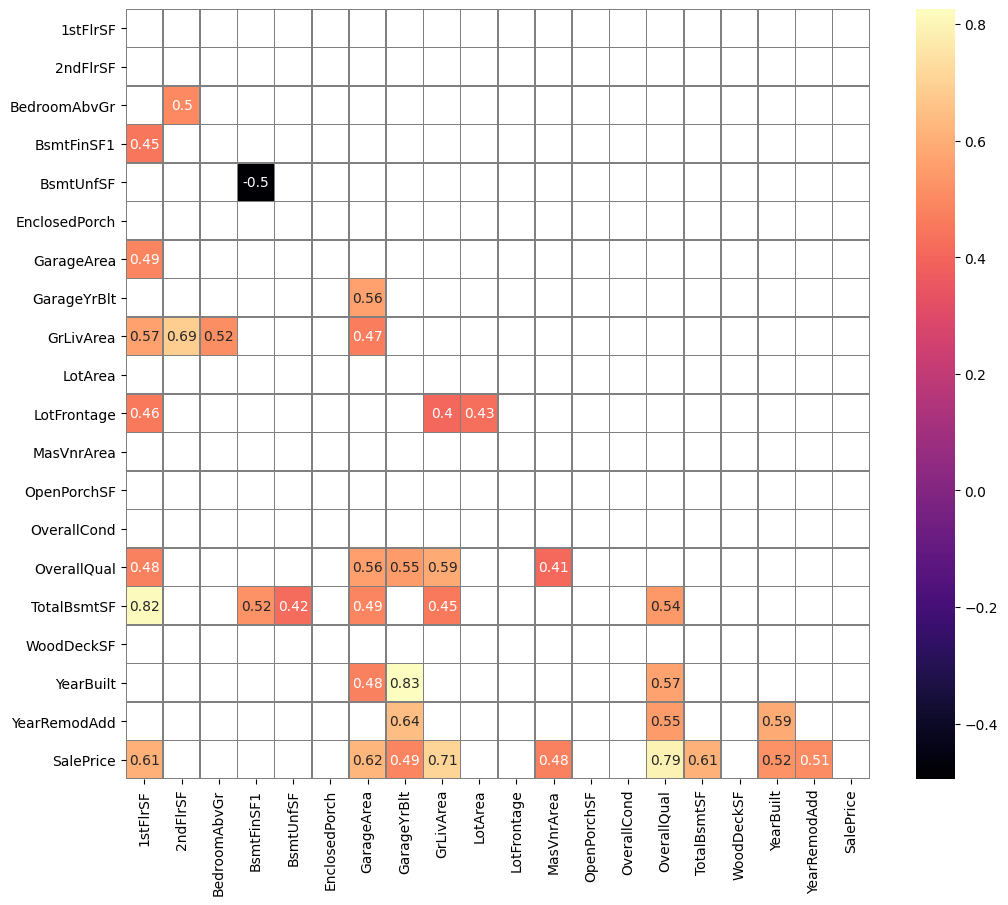

Pearson Correlation Heatmap (Linear relationships):


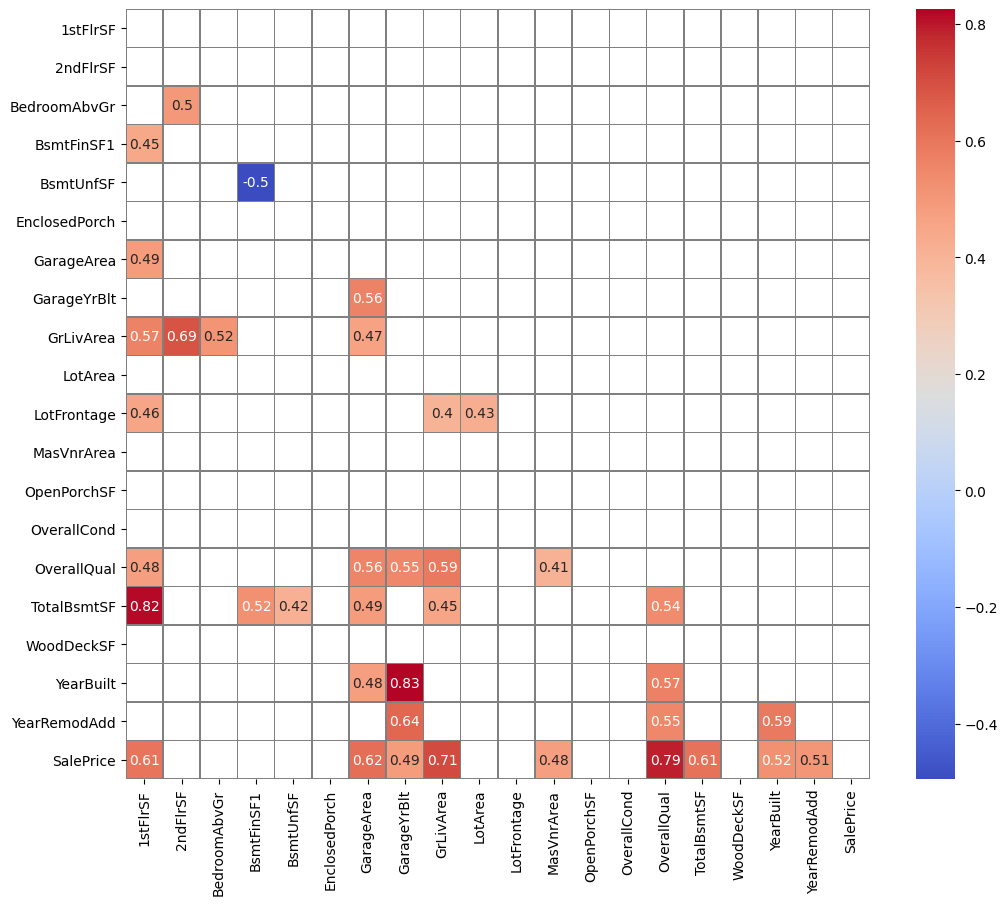

Power Predictive Score (PPS) Heatmap:


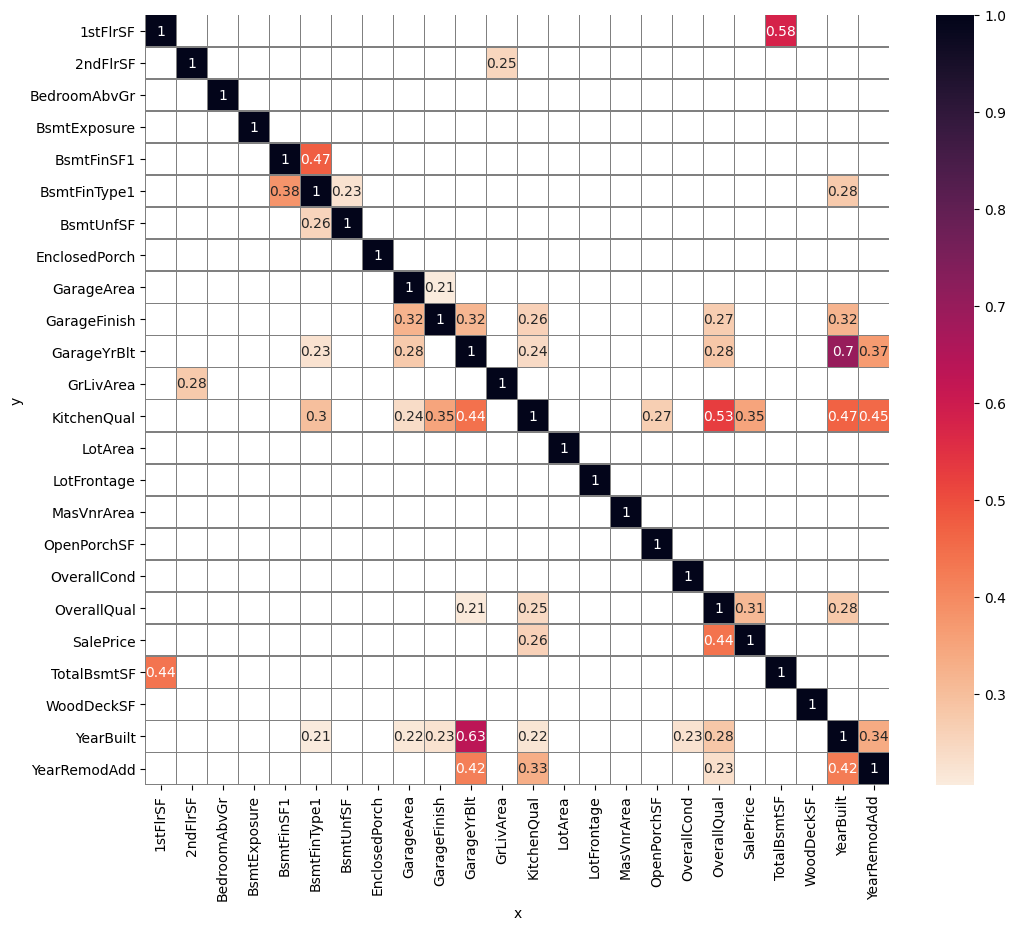

In [15]:
df_corr_pearson, df_corr_spearman, pps_matrix = compute_correlation_and_pps(df)

display_heatmaps(
    pearson_corr=df_corr_pearson, 
    spearman_corr=df_corr_spearman, 
    pps_matrix=pps_matrix, 
    corr_threshold=0.4, 
    pps_threshold=0.2, 
    figsize=(12, 10), 
    font_size=10
)


## Data Cleaning

### Function to create a DataFrame to hold missing data statistics. 

In [16]:
def evaluate_missing_data(df):
    """
    Analyse variables with missing values
    """
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / df.shape[0] * 100).round(2)
    

    # Create a DataFrame to hold the missing data statistics. 
    missing_data_df = pd.DataFrame({
        "RowsWithMissingData": missing_counts,
        "PercentageOfDataset": missing_percentage,
        "DataType": df.dtypes
    })

    # Filter to include only columns with missing data and sort.
    missing_data_df = missing_data_df[missing_data_df["PercentageOfDataset"] > 0]
    missing_data_df = missing_data_df.sort_values(by="PercentageOfDataset", ascending=False)

    return missing_data_df

In [17]:
evaluate_missing_data(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


- "EnclosedPorch" and "WoodDeckSF" have the most missing values at well over 80% each. I would deem these variables almost obsolete as they don't offer much in the way of predcting house prices. 

In [18]:
import pandas as pd

def plot_data_cleaning_effect(df_original, df_cleaned, variables_applied):
    """
    Visualizes the effect of data cleaning on selected variables by comparing distributions 
    between the original and cleaned datasets.

    Parameters:
        df_original (pd.DataFrame): The original dataset.
        df_cleaned (pd.DataFrame): The cleaned dataset.
        variables_applied (list): The variables to plot.
    """

    sns.set(style="whitegrid")
    
    # Identify categorical variables in the original dataset
    categorical_vars = df_original.select_dtypes(exclude=['number']).columns
    
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning on the following variables:")
    print(f"{variables_applied} \n\n")
    
    for idx, var in enumerate(variables_applied, start=1):
        plt.figure(figsize=(15, 5) if var in categorical_vars else (10, 5))
        
        # Plot categorical variables as bar plots
        if var in categorical_vars:
            df1 = pd.DataFrame({"Type": "Original", "Value": df_original[var]})
            df2 = pd.DataFrame({"Type": "Cleaned", "Value": df_cleaned[var]})
            combined_df = pd.concat([df1, df2])
            
            sns.countplot(data=combined_df, x="Value", hue="Type", palette=["#01BAEF", "#B80C09"])
            plt.xticks(rotation=90)
        
        # Plot numerical variables as histograms
        else:
            sns.histplot(df_original[var], color="#432371", label="Original", kde=True, element="step")
            sns.histplot(df_cleaned[var], color="#FAAE7B", label="Cleaned", kde=True, element="step")
        
        plt.title(f"Distribution Plot {idx}: {var}")
        plt.legend()
        plt.show()

## CategoricalVariableImputer


- **Purpose:** Used to handle missing values in **categorical features (i.e, variables that take on a limited, discrete set of values).** 


## Arbitrary Number Imputer


- **Purpose:** Used for both **numerical** and **categorical** variables to fill in missing values with an **arbitrary value** that doesn't naturally occur in data. 


## Mean/Median Imputer


- **Purpose:** Used primarily for **numerical values** where missing values are replaced by the **mean** or **median** of the column.


* Distribution Effect Analysis After Data Cleaning on the following variables:
['GarageFinish', 'BsmtFinType1'] 




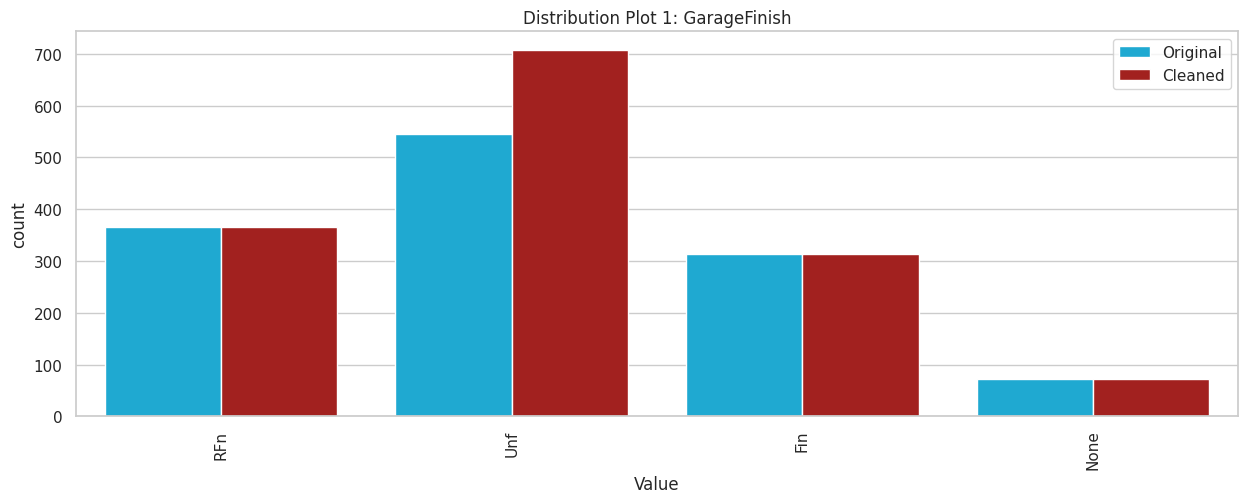

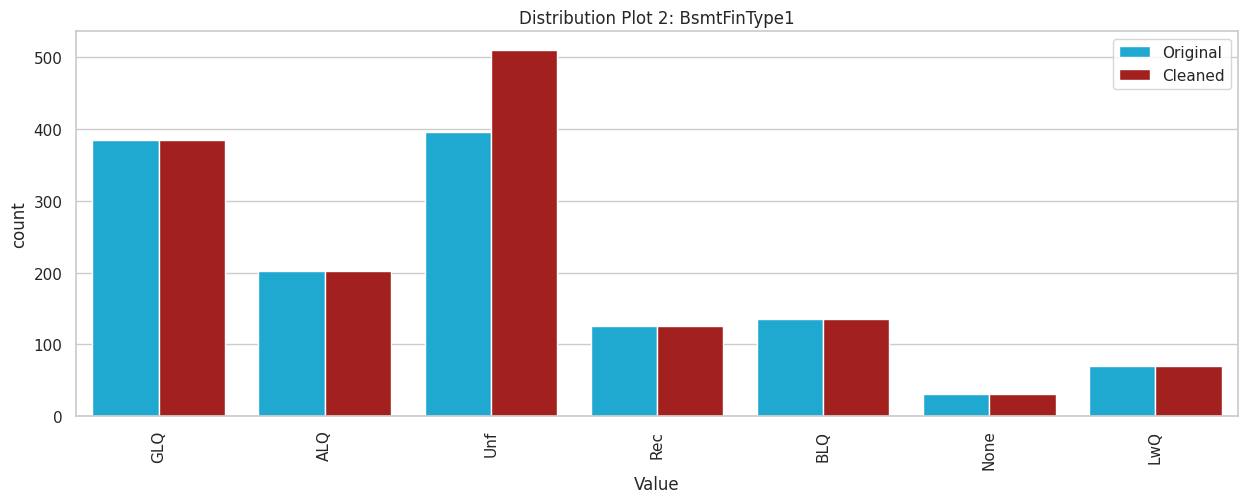

In [19]:
# Import the necessary imputation class
from feature_engine.imputation import CategoricalImputer

# Define the variables to impute
variables_to_impute = ["GarageFinish", "BsmtFinType1"]

# Instantiate the imputer with specific parameters
imputer = CategoricalImputer(imputation_method="missing", fill_value="Unf", variables=variables_to_impute)

# Apply the imputer to the DataFrame
df_imputed = imputer.fit_transform(df)

# Plot and compare the effect of imputation
plot_data_cleaning_effect(df_original=df, 
                          df_cleaned=df_imputed, 
                          variables_applied=variables_to_impute)


* Distribution Effect Analysis After Data Cleaning on the following variables:
['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea', 'WoodDeckSF'] 




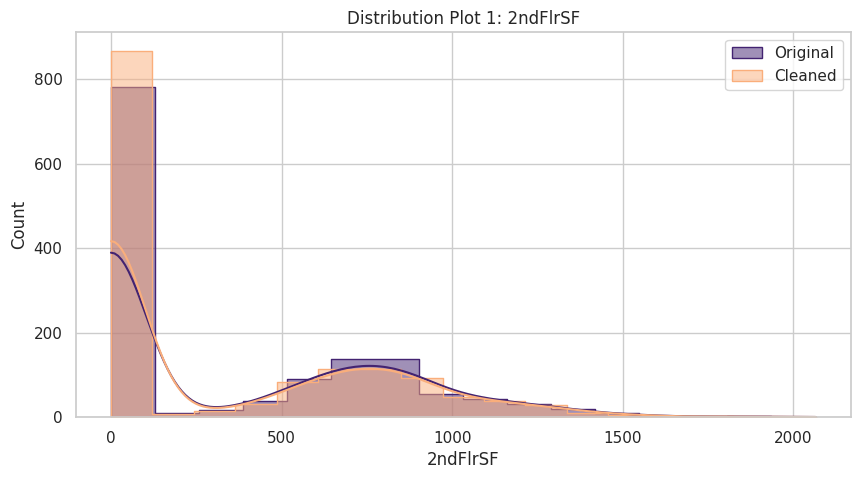

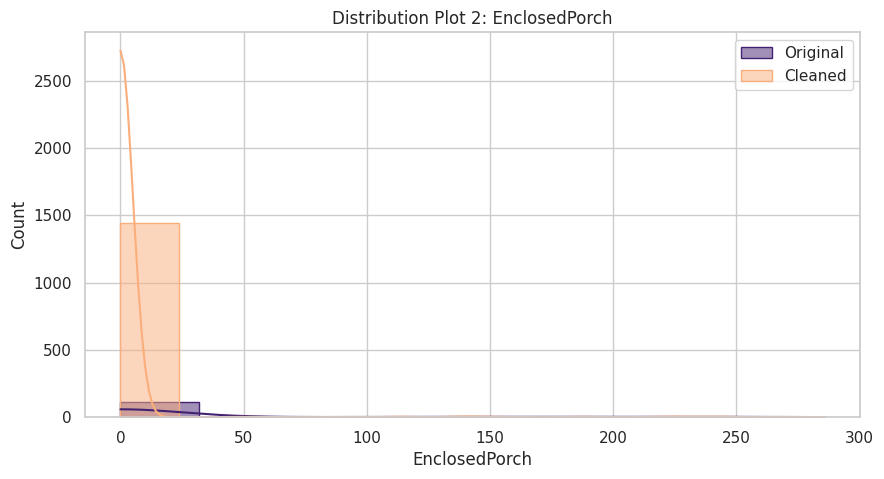

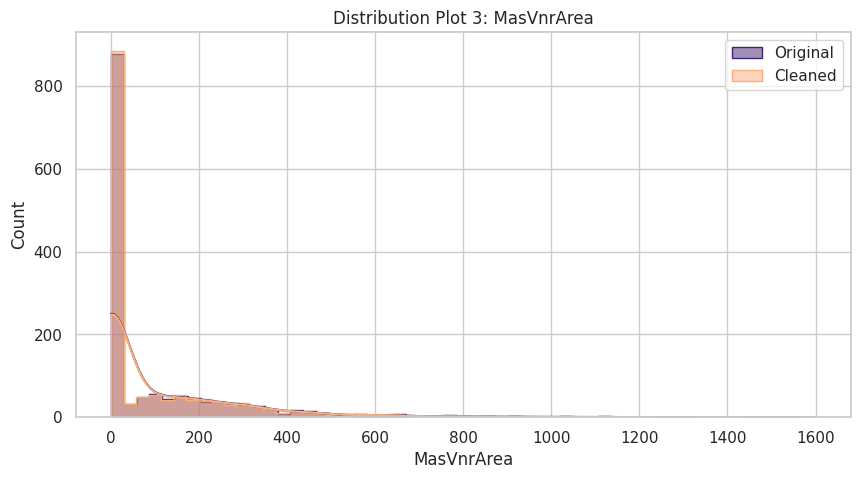

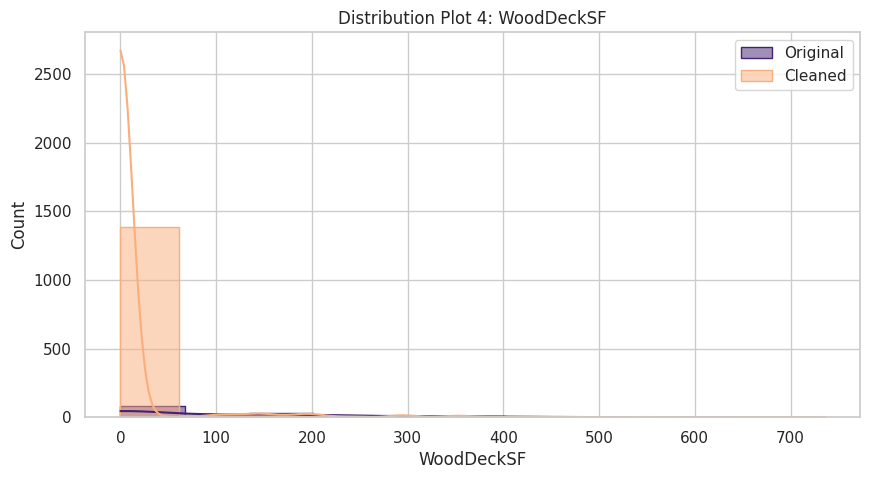

In [20]:
# Import the necessary imputation class
from feature_engine.imputation import ArbitraryNumberImputer

# Define the variables to impute
variables_to_impute = ["2ndFlrSF", "EnclosedPorch", "MasVnrArea", "WoodDeckSF"]

# Instantiate the imputer with specific parameters
imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_to_impute)

# Apply the imputer to the DataFrame
df_imputed = imputer.fit_transform(df)

# Plot and compare the effect of imputation
plot_data_cleaning_effect(df_original=df, 
                          df_cleaned=df_imputed, 
                          variables_applied=variables_to_impute)


* Distribution Effect Analysis After Data Cleaning on the following variables:
['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'] 




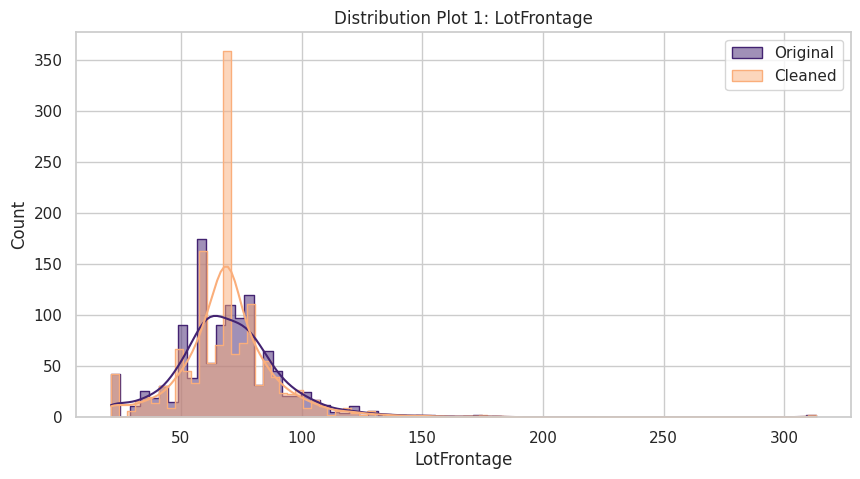

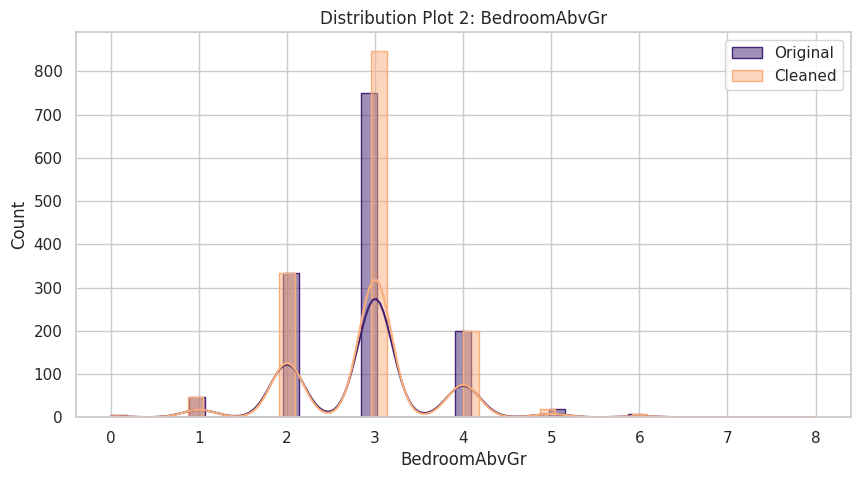

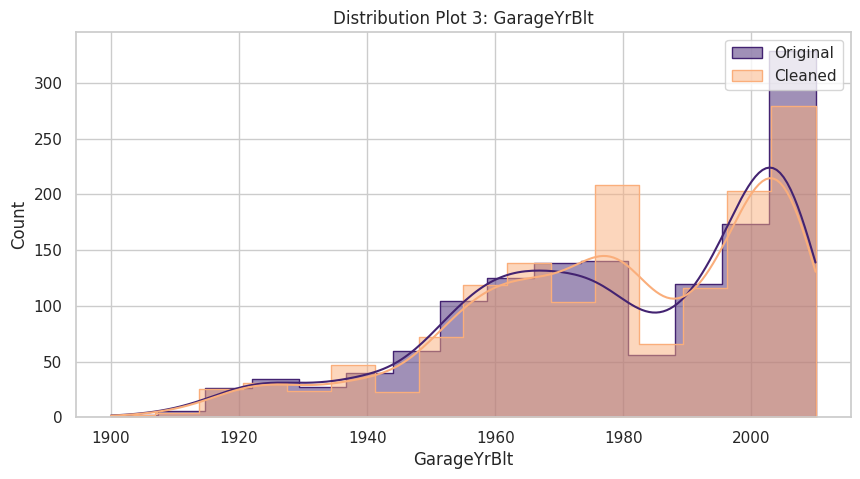

In [21]:
# Import the necessary imputation class
from feature_engine.imputation import MeanMedianImputer

# Define the variables to impute
variables_to_impute = ["LotFrontage", "BedroomAbvGr", "GarageYrBlt"]

# Instantiate the imputer with specific parameters
imputer = MeanMedianImputer(imputation_method="median", variables=variables_to_impute)

# Apply the imputer to the DataFrame
df_imputed = imputer.fit_transform(df)

# Plot and compare the effect of imputation
plot_data_cleaning_effect(df_original=df, 
                          df_cleaned=df_imputed, 
                          variables_applied=variables_to_impute)

In [22]:
# Shuffle the DataFrame
shuffled_df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Calculate the index for splitting
split_index = int(0.8 * len(shuffled_df))

# Create the training and testing sets
TrainSet = shuffled_df.iloc[:split_index]
TestSet = shuffled_df.iloc[split_index:]

# Get the SalePrice column
y_train = TrainSet["SalePrice"]
y_test = TestSet["SalePrice"]

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [23]:
# Define variables to impute
variables_to_impute =["GarageFinish", "BsmtFinType1"]

variables_method = variables_to_impute

# Create a CategoricalImputer instance with specified parameters
imputer = CategoricalImputer(
    imputation_method = "missing",
    fill_value = "Unf",
    variables=variables_method
)

# Fit the imputer on training set
imputer.fit(TrainSet)

# Apply the transformation to both the training and test sets
TrainSet = imputer.transform(TrainSet)
TestSet = imputer.transform(TestSet)

In [25]:
# Define variables to impute
variables_to_impute =["2ndFlrSF", "EnclosedPorch", "MasVnrArea", "WoodDeckSF"]

variables_method = variables_to_impute

# Create a ArbitraryNumberImputer instance with specified parameters
imputer = ArbitraryNumberImputer(
    arbitrary_number=0,
    variables=variables_method
)

# Fit the imputer on training set
imputer.fit(TrainSet)

# Apply the transformation to both the training and test sets
TrainSet = imputer.transform(TrainSet)
TestSet = imputer.transform(TestSet)

In [27]:
# Define variables to impute
variables_to_impute =["LotFrontage", "BedroomAbvGr", "GarageYrBlt"]

variables_method = variables_to_impute

# Create a MeanMedianImputer instance with specified parameters
imputer = MeanMedianImputer(
    imputation_method="median",
    variables=variables_method
)

# Fit the imputer on training set
imputer.fit(TrainSet)

# Apply the transformation to both the training and test sets
TrainSet = imputer.transform(TrainSet)
TestSet = imputer.transform(TestSet)

In [28]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') 
except Exception as e:
  print(e)

In [29]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

In [30]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)